<a href="https://colab.research.google.com/github/vigneshvalliappan/MSAI_CV_Project/blob/main/Playground/VGG_19L_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time

In [ ]:
from __future__ import print_function, division
import os
from skimage import io, transform

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
# decide whether to compute using GPU

device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [ ]:
fold_0 = pd.read_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/fold_0_data.txt',sep='\t')
fold_1 = pd.read_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/fold_1_data.txt',sep='\t')
fold_2 = pd.read_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/fold_2_data.txt',sep='\t')
fold_3 = pd.read_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/fold_3_data.txt',sep='\t')
fold_4 = pd.read_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/fold_4_data.txt',sep='\t')
fold_combined = pd.concat([fold_0,fold_1,fold_2,fold_3,fold_4],ignore_index=True)
print(f'Number of rows: {len(fold_combined)}')
fold_combined.info()

Number of rows: 19370
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [ ]:
fold_combined.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


['(25, 32)' '(38, 43)' '(4, 6)' '(60, 100)' '(15, 20)' '(48, 53)'
 '(8, 12)' '(0, 2)' 'None' '(38, 48)' '35' '3' '55' '58' '22' '13' '45'
 '36' '23' '(38, 42)' '(8, 23)' '(27, 32)' '57' '56' '2' '29' '34' '42'
 '46' '32']


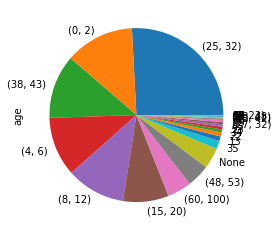

In [ ]:
# age break down
print(fold_combined.age.unique())
fold_combined.age.value_counts().plot.pie()

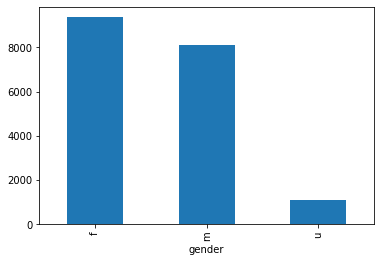

In [ ]:
# gender break down
fold_combined.groupby(['gender'])['gender'].count().plot.bar()

In [ ]:
# new column to record the file path
fold_combined['image_path'] = '/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/faces/' + fold_combined['user_id'] + '/coarse_tilt_aligned_face.' + fold_combined['face_id'].astype('str') + '.' + fold_combined['original_image']
fold_combined['image_path']

0        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
1        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
2        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
3        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
4        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
                               ...                        
19365    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19366    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19367    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19368    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19369    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
Name: image_path, Length: 19370, dtype: object

In [ ]:
# new column to record the landmarks file
fold_combined['landmarks_path'] = '/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/faces/' + fold_combined['user_id'] + '/landmarks.' + fold_combined['face_id'].astype('str') + '.' + fold_combined['original_image'].apply(lambda x: x[:len(x)-3]) + 'txt'
fold_combined['landmarks_path']

0        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
1        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
2        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
3        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
4        /content/drive/MyDrive/MSAI CV/MSAI CV Project...
                               ...                        
19365    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19366    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19367    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19368    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
19369    /content/drive/MyDrive/MSAI CV/MSAI CV Project...
Name: landmarks_path, Length: 19370, dtype: object

In [ ]:
# filtered of unlabelled data
print(len(fold_combined))
fold_combined = fold_combined[fold_combined['age'] != 'None']
fold_combined = fold_combined[fold_combined['gender'] != 'u']
fold_combined = fold_combined[fold_combined['gender'].notna()]
print(len(fold_combined))

19370
17452


In [ ]:
# formulating age class
with open('/content/drive/MyDrive/MSAI CV/MSAI CV Project/Data/age_class.json') as f:
    age_class = json.load(f)

fold_combined['age'] = fold_combined['age'].apply(lambda x: age_class[x])
fold_combined.age.value_counts()

25-36    5493
38-47    2435
8-14     2286
4-6      2139
15-24    1885
0-3      1418
48-59     930
60+       866
Name: age, dtype: int64

In [ ]:
# convert class to int
def labelling_age(age_range):
    if age_range == '0-3':
        return 0
    elif age_range == '4-6':
        return 1
    elif age_range == '8-14':
        return 2
    elif age_range == '15-24':
        return 3
    elif age_range == '25-36':
        return 4
    elif age_range == '38-47':
        return 5
    elif age_range == '48-59':
        return 6
    elif age_range == '60+':
        return 7


fold_combined['label_age'] = fold_combined['age'].apply(labelling_age)
fold_combined.label_age.value_counts()

4    5493
5    2435
2    2286
1    2139
3    1885
0    1418
6     930
7     866
Name: label_age, dtype: int64

In [ ]:
# gender class
fold_combined.gender.value_counts()

f    9332
m    8120
Name: gender, dtype: int64

In [ ]:
# convert class to int
def labelling_gender(gender_range):
    if gender_range == 'm':
        result = 0
    elif gender_range == 'f':
        result = 1
    else:
        print(gender_range)
    return result

fold_combined['label_gender'] = fold_combined['gender'].apply(labelling_gender)
fold_combined.label_gender.value_counts()

1    9332
0    8120
Name: label_gender, dtype: int64

In [ ]:
fold_combined

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,image_path,landmarks_path,label_age,label_gender
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,25-36,f,0,414,1086,1383,-115,30,17,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,4,1
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,25-36,m,301,105,640,641,0,0,94,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,4,0
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,25-36,f,2395,876,771,771,175,-30,74,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,4,1
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,25-36,m,752,1255,484,485,180,0,47,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,4,0
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,25-36,m,175,80,769,768,-75,0,34,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19341,101515718@N03,10587826073_6663f5b654_o.jpg,2280,25-36,f,718,748,492,492,0,0,63,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,4,1
19342,101515718@N03,10587571495_a61785cd06_o.jpg,2278,25-36,m,48,472,768,768,-15,0,25,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,4,0
19343,101515718@N03,10587571495_a61785cd06_o.jpg,2279,25-36,f,950,0,692,687,-5,0,27,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,4,1
19344,50458575@N08,9426695459_9e8b347604_o.jpg,2281,25-36,f,831,895,899,899,0,15,59,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,/content/drive/MyDrive/MSAI CV/MSAI CV Project...,4,1


In [ ]:
row_index = 4
landmark_eg= pd.read_csv(fold_combined.loc[row_index, 'landmarks_path'])
print(landmark_eg)

img_eg_path = fold_combined.loc[row_index, 'image_path']
landmark_eg = np.asarray(landmark_eg)[1:]
landmark_eg = landmark_eg.astype('float').reshape(-1, 2)

print(landmark_eg)
print('Image name: {}'.format(img_eg_path))
print('Landmarks shape: {}'.format(landmark_eg.shape))
print('First 4 Landmarks: {}'.format(landmark_eg[:4]))

                               69       0
x      y      dx    dy        x_c     y_c
265.31 265.31 65.51 65.51  298.07  298.07
251.12 265.31 65.51 65.51  283.87  298.07
                    65.51  283.87  298.07
278.41 265.31 65.51 65.51  311.17  298.07
...                           ...     ...
397.42 317.72 65.51 65.51  430.18  350.47
410.52 291.52 65.51 65.51  443.28  324.27
423.63 265.31 65.51 65.51  456.38  298.07
       224.91 65.51 65.51  456.38  257.67
       185.61 65.51 65.51  456.38  218.36

[69 rows x 2 columns]
[[298.07 298.07]
 [283.87 298.07]
 [283.87 298.07]
 [311.17 298.07]
 [311.17 298.07]
 [298.07 283.87]
 [298.07 270.77]
 [298.07 244.57]
 [298.07 231.47]
 [257.67 244.57]
 [257.67 244.57]
 [244.57 244.57]
 [244.57 231.47]
 [244.57 231.47]
 [231.47 244.57]
 [192.16 218.36]
 [205.26 205.26]
 [218.36 192.16]
 [244.57 205.26]
 [257.67 218.36]
 [350.47 231.47]
 [363.58 231.47]
 [376.68 231.47]
 [350.47 218.36]
 [363.58 218.36]
 [376.68 218.36]
 [417.07 192.16]
 [403.97 192.1

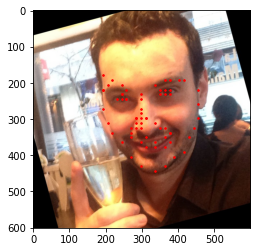

In [ ]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(img_eg_path),landmark_eg)
plt.show()

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, model, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #self.landmarks_frame = pd.read_csv(csv_file)
        self.dataset_df = pd.read_csv(csv_file)
        self.model = model
        self.transform = transform

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        landmark_sample = pd.read_csv(self.dataset_df.loc[idx, 'landmarks_path'])

        img_sample_path = self.dataset_df.loc[idx, 'image_path']
        landmark_sample = np.asarray(landmark_sample)[1:]
        landmark_sample = landmark_sample.astype('float').reshape(-1, 2)

        image_sample = io.imread(img_sample_path)
        #image_sample = image_sample.astype('float')

        if self.model == 'gender':
            label = self.dataset_df['label_gender'][idx]
        elif self.model == 'age':
            label = self.dataset_df['label_age'][idx]
        else:
            print('Please specify "gender" or "age".')
            label = None

        label = np.asarray(label)

        #sample = {'image': image_sample, 'landmarks': landmark_sample, 'label': label}
        sample = (image_sample, landmark_sample, label)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
fold_combined.to_csv('/content/drive/MyDrive/MSAI CV/MSAI CV Project/fold_combined.csv')

0 (600, 764, 3) (68, 2) () 1
0 uint8 float64 int64


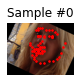

1 (601, 600, 3) (68, 2) () 0
1 uint8 float64 int64


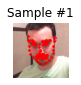

2 (600, 600, 3) (68, 2) () 1
2 uint8 float64 int64


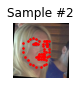

3 (485, 484, 3) (68, 2) () 0
3 uint8 float64 int64


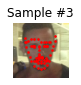

4 (601, 600, 3) (68, 2) () 0
4 uint8 float64 int64


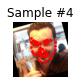

In [ ]:
face_dataset_trial = FaceLandmarksDataset(csv_file='/content/drive/MyDrive/MSAI CV/MSAI CV Project/fold_combined.csv', model = 'gender')

fig = plt.figure()

for i in range(len(face_dataset_trial)):
    sample = face_dataset_trial[i]

    #print(i, sample['image'].shape, sample['landmarks'].shape, sample['label'].shape, sample['label'])
    print(i, sample[0].shape, sample[1].shape, sample[2].shape, sample[2])
    print(i, sample[0].dtype, sample[1].dtype, sample[2].dtype)

    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(sample[0], sample[1])

    if i == 4:
        break

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        #image, landmarks, label = sample['image'], sample['landmarks'], sample['label']
        image, landmarks, label = sample[0], sample[1], sample[2]

        h, w = image.shape[:2]
        #if isinstance(self.output_size, int):
            #if h > w:
            #    new_h, new_w = self.output_size * h / w, self.output_size
            #else:
            #    new_h, new_w = self.output_size, self.output_size * w / h
        #else:
        new_h, new_w = self.output_size, self.output_size 

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        #return {'image': img, 'landmarks': landmarks, 'label': label}
        return (img, landmarks, label)

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        #image, landmarks, label = sample['image'], sample['landmarks'], sample['label']
        image, landmarks, label = sample[0], sample[1], sample[2]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        landmarks = landmarks - [left, top]

        #return {'image': image, 'landmarks': landmarks, 'label': label}
        return (image, landmarks, label)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        #image, landmarks, label = sample['image'], sample['landmarks'], sample['label']
        image, landmarks, label = sample[0], sample[1], sample[2]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return (torch.from_numpy(image), torch.from_numpy(landmarks), torch.from_numpy(label))

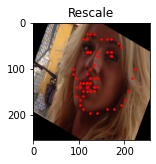

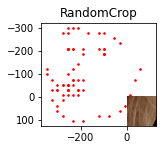

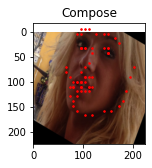

In [ ]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset_trial[0]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    #show_landmarks(transformed_sample['image'], transformed_sample['landmarks'])
    show_landmarks(transformed_sample[0], transformed_sample[1])

plt.show()

In [ ]:
transformed_dataset = FaceLandmarksDataset(csv_file = '/content/drive/MyDrive/MSAI CV/MSAI CV Project/fold_combined.csv', model = 'gender', transform=transforms.Compose([Rescale(256), ToTensor()]))

print(len(transformed_dataset))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    #print(i, sample['image'].size(), sample['landmarks'].size(), sample['label'].size())
    print(i, sample[0].size(), sample[1].size(), sample[2].size())

    if i == 5:
        break

17452
0 torch.Size([3, 256, 256]) torch.Size([68, 2]) torch.Size([])
1 torch.Size([3, 256, 256]) torch.Size([68, 2]) torch.Size([])
2 torch.Size([3, 256, 256]) torch.Size([68, 2]) torch.Size([])
3 torch.Size([3, 256, 256]) torch.Size([68, 2]) torch.Size([])
4 torch.Size([3, 256, 256]) torch.Size([68, 2]) torch.Size([])
5 torch.Size([3, 256, 256]) torch.Size([68, 2]) torch.Size([])


In [ ]:
criterion = nn.CrossEntropyLoss()
my_lr=0.25 
bs= 20

655
train feature batch shape: torch.Size([20, 3, 256, 256])
train labels batch shape: torch.Size([20])
219
test feature batch shape: torch.Size([20, 3, 256, 256])
test labels batch shape: torch.Size([20])
0 torch.Size([20, 3, 256, 256]) torch.Size([20, 68, 2]) torch.Size([20])
1 torch.Size([20, 3, 256, 256]) torch.Size([20, 68, 2]) torch.Size([20])
2 torch.Size([20, 3, 256, 256]) torch.Size([20, 68, 2]) torch.Size([20])
3 torch.Size([20, 3, 256, 256]) torch.Size([20, 68, 2]) torch.Size([20])


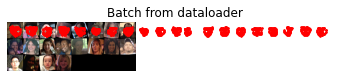

In [ ]:

train_instances = round(len(transformed_dataset)*0.75)
test_instances = len(transformed_dataset) - train_instances

train_dataset, test_dataset = torch.utils.data.random_split(transformed_dataset, [train_instances, test_instances], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
print(len(train_dataloader))
#print(next(iter(train_dataloader)))

train_features, _, train_labels = next(iter(train_dataloader))
print(f"train feature batch shape: {train_features.size()}")
print(f"train labels batch shape: {train_labels.size()}")


test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True, num_workers=0)
print(len(test_dataloader))
#print(next(iter(test_dataloader)))

test_features, _, test_labels = next(iter(test_dataloader))
print(f"test feature batch shape: {test_features.size()}")
print(f"test labels batch shape: {test_labels.size()}")


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    #images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    images_batch, landmarks_batch = sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size, landmarks_batch[i, :, 1].numpy() + grid_border_size, s=10, marker='.', c='r')

        plt.title('Batch from dataloader')


for i_batch, sample_batched in enumerate(train_dataloader):
    #print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
    print(i_batch, sample_batched[0].size(), sample_batched[1].size(), sample_batched[2].size())

    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# Gender Model

In [ ]:
#X = fold_combined['filepath']
#y = fold_combined['label_gender']

In [ ]:
#from sklearn.model_selection import train_test_split

#X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=99)

#print(f'train X shape: {len(X_train)}')
#print(f'test x shape: {len(X_test)}')
#print(f'train y shape: {len(y_train)}')
#print(f'test y shape: {len(y_test)}')

In [ ]:
#y_train = torch.from_numpy(np.asarray(y_train))
#y_train = y_train.type(torch.long)
#y_test = torch.from_numpy(np.asarray(y_test))
#y_test = y_test.type(torch.long)

#print(f'y_train: {y_train.size()}')
#print(f'y_test: {y_test.size()}')

In [ ]:
#from PIL import Image

#def get_image(series):
#    results = []
#    for row in series:
#        image = Image.open(row)
#        image = image.resize((256,256))
#        results.append(np.asarray(image))
#    return results

# convert list to array to tensor
#X_train_images = torch.from_numpy(np.asarray(get_image(X_train)))
#X_train_images = X_train_images.permute(0, 3, 1, 2)
#X_train_images = X_train_images.type(torch.float)
#print(f'X_train_images: {X_train_images.size()}')

#X_test_images = torch.from_numpy(np.asarray(get_image(X_test)))
#X_test_images = X_test_images.permute(0, 3, 1, 2)
#X_test_images = X_test_images.type(torch.float)
#print(f'X_test_images: {X_test_images.size()}')


In [ ]:
class model_gender(nn.Module): # VGG_convnet 19 layers

    def __init__(self):
        super(model_gender,self).__init__()

        # block 1:         3 x 256 x 256 --> 64 x 64 x 64        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.conv1c = nn.Conv2d(64,  64,  kernel_size=3, padding=1 ) # added this layer
        self.pool1  = nn.MaxPool2d(4,4)

        # block 2:         64 x 64 x 64 --> 128 x 16 x 16
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.conv2c = nn.Conv2d(128, 128, kernel_size=3, padding=1 ) # added this layer
        self.pool2  = nn.MaxPool2d(4,4)

        # block 3:         128 x 16 x 16 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.conv3c = nn.Conv2d(256, 256, kernel_size=3, padding=1 ) # added this layer
        self.conv3d = nn.Conv2d(256, 256, kernel_size=3, padding=1 ) # added this layer
        self.conv3e = nn.Conv2d(256, 256, kernel_size=3, padding=1 ) # added this layer
        self.pool3  = nn.MaxPool2d(4,4)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.conv4b = nn.Conv2d(512, 512, kernel_size=3, padding=1 ) # added this layer
        self.conv4c = nn.Conv2d(512, 512, kernel_size=3, padding=1 ) # added this layer
        self.conv4d = nn.Conv2d(512, 512, kernel_size=3, padding=1 ) # added this layer
        self.conv4e = nn.Conv2d(512, 512, kernel_size=3, padding=1 ) # added this layer
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)
        
    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.conv1b(x)
        x = torch.relu(x)
        x = self.conv1c(x) # added this
        x = torch.relu(x) # added this
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = torch.relu(x)
        x = self.conv2b(x) 
        x = torch.relu(x)
        x = self.conv2c(x) # added this
        x = torch.relu(x) # added this
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.conv3b(x)
        x = torch.relu(x)
        x = self.conv3c(x) # added this
        x = torch.relu(x) # added this
        x = self.conv3d(x) # added this
        x = torch.relu(x) # added this
        x = self.conv3e(x) # added this
        x = torch.relu(x) # added this
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.conv4b(x) # added this
        x = torch.relu(x) # added this
        x = self.conv4c(x) # added this
        x = torch.relu(x) # added this
        x = self.conv4d(x) # added this
        x = torch.relu(x) # added this
        x = self.conv4e(x) # added this
        x = torch.relu(x) # added this
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 
        
        return x

In [ ]:
net_gender = model_gender()
print(net_gender)

model_gender(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1c): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2c): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3c): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3d): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3e): Conv2d(256

In [ ]:
# send net_gender to device
net_gender = net_gender.to(device)

In [ ]:
#mean = X_train_images.mean()
#print(mean)
#std = X_train_images.std()
#print(std)

In [ ]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs    

In [ ]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,len(test_dataloader),bs):

        #minibatch_data =  X_test_images[i:i+bs]
        #minibatch_label= y_test[i:i+bs]

        minibatch_data, _, minibatch_label=  next(iter(test_face_loader))

        #send to GPU, if desired
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std

        scores=net_gender( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

In [ ]:
start=time.time()

#for epoch in range(1,20):
for epoch in range(2):

    # divide the learning rate by 2 at epoch 10, 14 and 18
    #if epoch==10 or epoch == 14 or epoch==18:
    if epoch==1:
      my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net_gender.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    # shuffled_indices=torch.randperm(13089)
 
    for count in range(0,len(train_dataloader),bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        
        # indices=shuffled_indices[count:count+bs]
        # minibatch_data =  X_train_images[indices]
        # minibatch_label=  y_train[indices]

        minibatch_data, _, minibatch_label = next(iter(train_dataloader))

        minibatch_data = minibatch_data.float()

        # send them to the gpu, if desired
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # normalize the minibatch (this is the only difference compared to before!)
        #inputs = (minibatch_data - mean)/std
        inputs = minibatch_data

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net_gender( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        
        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
        print(f'{num_batches} : {(time.time()-start)/60}')
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')

1 : 0.38103746573130287
2 : 0.7374395291010539
3 : 1.1199090758959451
4 : 1.5268794814745585
5 : 1.9342390298843384
6 : 2.319557285308838
7 : 2.702097396055857
8 : 3.0883623878161113
9 : 3.467995285987854
10 : 3.8378218332926433
11 : 4.19453288714091


KeyboardInterrupt: ignored